<a href="https://colab.research.google.com/github/Stanley-Wang910/spotify-rec-engine/blob/fixes-branch/genre_classifier_xgboost.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import files

uploaded = files.upload()

Saving rec_dataset.csv to rec_dataset.csv


### Libraries & Imports

In [3]:
import pandas as pd
import random
import numpy as np
from sklearn.preprocessing import LabelEncoder
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import numpy as np
from scipy import stats
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.preprocessing import LabelEncoder, StandardScaler
import plotly.express as px
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture
import seaborn as sns
import matplotlib.pyplot as plt

### Read Data

In [4]:
# Will need to import rec_dataset

random.seed(12975910)
df = pd.read_csv('rec_dataset.csv')
df.dropna(how='all', inplace=True)
df.drop_duplicates(subset='track_id', inplace=True)
df = df.drop('time_signature', axis=1)
print(df.isnull().sum())
df = df.groupby('track_genre').apply(lambda x: x.sample(min(len(x), 5000))).reset_index(drop=True)
print(df['track_genre'].value_counts())
df.head()

artists             1
track_name          2
track_id            0
popularity          0
duration_ms         0
danceability        0
energy              0
key                 0
loudness            0
mode                0
speechiness         0
acousticness        0
instrumentalness    0
liveness            0
valence             0
tempo               0
track_genre         0
dtype: int64
track_genre
Alternative    5000
Anime          5000
Soundtrack     5000
Soul           5000
Rock           5000
Reggaeton      5000
Reggae         5000
R&B            5000
Pop            5000
Opera          5000
Jazz           5000
Indie          5000
Hip-Hop        5000
Folk           5000
Electronic     5000
Dance          5000
Country        5000
Classical      5000
Blues          5000
World          5000
Name: count, dtype: int64


artists                   track_name                track_id  \
0            Hannah Kerr                Split the Sea  6VWwx9RvQadw4APUH0YrpR   
1  Red Hot Chili Peppers            Me And My Friends  3eiIQPGp6biDu91bKgAEzg   
2                Gallant  Doesn't Matter - Rynx Remix  0Xr5SrLHtrQ8vD1dDkqxRV   
3              Disturbed       Down with the Sickness  40rvBMQizxkIqnjPdEWY1v   
4     Coheed and Cambria                  Lucky Stars  5OsacxcT1SHN3TfdmA8FGs   

   popularity  duration_ms  danceability  energy  key  loudness  mode  \
0          45       209507         0.531   0.711    5    -4.874     1   
1          49       189133         0.586   0.996    2    -2.296     1   
2          46       184581         0.640   0.852    1    -5.272     1   
3          70       279213         0.695   0.876    3    -4.262     0   
4          40       309013         0.582   0.406    0   -10.406     1   

   speechiness  acousticness  instrumentalness  liveness  valence    tempo  \
0       0.0583      0.244000          0.000000    0.1630    0.291  149.645   
1       0.1440      0.021500          0.000015    0.1930    0.173  100.130   
2       0.0322      0.028000          0.000003    0.0773    0.689  127.954   
3       0.0553      0.000996          0.000007    0.1060    0.941   89.954   
4       0.0280      0.641000          0.000010    0.0747    0.220  115.919   

   track_genre  
0  Alternative  
1  Alternative  
2  Alternative  
3  Alternative  
4  Alternative

### Visualize Data

In [5]:
na_rows = df[df.isna().any(axis=1)]
df['duration_ms'] = df['duration_ms']
df.replace(to_replace=['?', -1], value=np.nan, inplace=True)


percent_missing = df.isna().mean() * 100
for column, percentage in percent_missing.items():
    print(f"{column}: {percentage:.4f}% missing values")
na_rows

artists: 0.0010% missing values
track_name: 0.0010% missing values
track_id: 0.0000% missing values
popularity: 0.0000% missing values
duration_ms: 0.0000% missing values
danceability: 0.0000% missing values
energy: 0.0000% missing values
key: 0.0000% missing values
loudness: 0.0000% missing values
mode: 0.0000% missing values
speechiness: 0.0000% missing values
acousticness: 0.0000% missing values
instrumentalness: 0.0000% missing values
liveness: 0.0000% missing values
valence: 0.0000% missing values
tempo: 0.0000% missing values
track_genre: 0.0000% missing values


artists track_name                track_id  popularity  duration_ms  \
62542     NaN        NaN  1kR4gIb7nGxHPI3D2ifs59           0            0   

       danceability  energy  key  loudness  mode  speechiness  acousticness  \
62542         0.501   0.583    7     -9.46     0       0.0605          0.69   

       instrumentalness  liveness  valence    tempo track_genre  
62542           0.00396    0.0747    0.734  138.391         Pop

In [6]:
unique_values = df['track_genre'].unique()
print(f"Unique values in column track_genre:", unique_values)

Unique values in column track_genre: ['Alternative' 'Anime' 'Blues' 'Classical' 'Country' 'Dance' 'Electronic'
 'Folk' 'Hip-Hop' 'Indie' 'Jazz' 'Opera' 'Pop' 'R&B' 'Reggae' 'Reggaeton'
 'Rock' 'Soul' 'Soundtrack' 'World']


### Preprocess the Data


In [8]:
df['tempo'] = pd.to_numeric(df['tempo'], errors='coerce')
df['duration_ms'] = pd.to_numeric(df['duration_ms'], errors='coerce')
df.dropna(subset=['tempo', 'duration_ms'], inplace=True)

df = df.drop(['artists', 'track_name', 'track_id'], axis=1)


label_encoder = LabelEncoder()
df['track_genre']  = label_encoder.fit_transform(df['track_genre'])
df = pd.get_dummies(df, columns=['key'], dtype=int)



df.head()

popularity  duration_ms  danceability  energy  loudness  mode  speechiness  \
0          45       209507         0.531   0.711    -4.874     1       0.0583   
1          49       189133         0.586   0.996    -2.296     1       0.1440   
2          46       184581         0.640   0.852    -5.272     1       0.0322   
3          70       279213         0.695   0.876    -4.262     0       0.0553   
4          40       309013         0.582   0.406   -10.406     1       0.0280   

   acousticness  instrumentalness  liveness  ...  key_2  key_3  key_4  key_5  \
0      0.244000          0.000000    0.1630  ...      0      0      0      1   
1      0.021500          0.000015    0.1930  ...      1      0      0      0   
2      0.028000          0.000003    0.0773  ...      0      0      0      0   
3      0.000996          0.000007    0.1060  ...      0      1      0      0   
4      0.641000          0.000010    0.0747  ...      0      0      0      0   

   key_6  key_7  key_8  key_9  key_10  key_11  
0      0      0      0      0       0       0  
1      0      0      0      0       0       0  
2      0      0      0      0       0       0  
3      0      0      0      0       0       0  
4      0      0      0      0       0       0  

[5 rows x 25 columns]

In [9]:
genres = df['track_genre'].unique()
train_frames = []
test_frames = []

for genre in genres:
  genre_data = df[df['track_genre'] == genre]
  # a test size of 500 per each genre instance, ensuring a total balanced test set
  genre_train, genre_test = train_test_split(genre_data, test_size=500, shuffle=True)
  train_frames.append(genre_train)
  test_frames.append(genre_test)

train_df = pd.concat(train_frames)
test_df = pd.concat(test_frames)

print(test_df['track_genre'].value_counts())

track_genre
0     500
1     500
18    500
17    500
16    500
15    500
14    500
13    500
12    500
11    500
10    500
9     500
8     500
7     500
6     500
5     500
4     500
3     500
2     500
19    500
Name: count, dtype: int64


### Dimensionality Reduction

In [ ]:
# To see which linear combination of features is most responsible for determining the variance of class items (genres)
# PCA didn't net good results, could potentially try re-fitting model using LDA reducd featuresets

columns_to_drop = [col for col in train_df.columns if 'key' in col or col == 'mode']
reduct_df = train_df.drop(columns=columns_to_drop)
X = reduct_df.drop('track_genre', axis=1)
y_encoded = reduct_df['track_genre']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

pca = PCA(n_components=3)

X_pca = pca.fit_transform(X_scaled)

pca_explained_variance = pca.explained_variance_ratio_
print(pca_explained_variance)

df_pca_result = pd.DataFrame(X_pca, columns=[f'PCA{i+1}' for i in range(X_pca.shape[1])])
df_pca_result['Track Genre'] = label_encoder.inverse_transform(y_encoded)

print("Inverse transformed labels: ", df_pca_result['Track Genre'].unique())

fig = px.scatter_3d(df_pca_result, x='PCA1', y='PCA2', z='PCA3',
                    color='Track Genre',
                    title="3D PCA Projection of Music Tracks",
                    opacity=1.0)

fig.update_traces(marker=dict(size=1))

fig.show()

# lda = LDA(n_components=3)

# X_lda = lda.fit_transform(X_scaled, y_encoded)

# lda_explained_variance = lda.explained_variance_ratio_
# print(lda_explained_variance)

# reduct_df_result = pd.DataFrame(X_lda, columns=[f'LDA{i+1}' for i in range(X_lda.shape[1])])
# reduct_df_result['Track Genre'] = label_encoder_reduct.inverse_transform(y_encoded)

# fig = px.scatter_3d(reduct_df_result, x='LDA1', y='LDA2', z='LDA3',
#                     color='Track Genre',
#                     title="3D LDA Projection of Music Tracks",
#                     opacity=1.0)

# fig.update_traces(marker=dict(size=1))

# fig.show()



377       0
1726      0
247       0
1704      0
3571      0
         ..
99705    19
95163    19
97625    19
98214    19
96785    19
Name: track_genre, Length: 90000, dtype: int64
[0.32925841 0.11318461 0.09806699]
Inverse transformed labels:  ['Alternative' 'Anime' 'Blues' 'Classical' 'Country' 'Dance' 'Electronic'
 'Folk' 'Hip-Hop' 'Indie' 'Jazz' 'Opera' 'Pop' 'R&B' 'Reggae' 'Reggaeton'
 'Rock' 'Soul' 'Soundtrack' 'World']


### Prepare Data for Model

### Fit Model


In [10]:
### Grid Search CV

X_train = train_df.drop('track_genre', axis=1)
y_train = train_df['track_genre']

X_test = test_df.drop('track_genre', axis=1)
y_test = test_df['track_genre']



# Define the parameter grid
params = {
    'max_depth': [2, 3, 4, 5, 7, 12],
    'eta': [0.1, 0.2, 0.3, 0.4, 0.5],
    'objective': ['multi:softmax'],
    'num_class': [len(y_train.unique())]
}

# Initialize the XGBClassifier with the checkpoint callback
base_model = xgb.XGBClassifier()

# Set up StratifiedKFold
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Initialize GridSearchCV with the checkpointing-enabled model
grid_search = GridSearchCV(
    estimator=base_model,
    param_grid=params,
    scoring='accuracy',
    cv=kf,
    verbose=2
)

# Fit the model
grid_search.fit(X_train, y_train)

print("Best parameters:", grid_search.best_params_)
print("Best cross-validation score: {:.2f}".format(grid_search.best_score_))

# Get the best model
best_model = grid_search.best_estimator_

# Make predictions on the test set
y_pred = best_model.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Test set accuracy: %.2f%%" % (accuracy * 100))

# Optional: Save the final best model
best_model.save_model("final_best_model.json")

Fitting 5 folds for each of 30 candidates, totalling 150 fits


KeyboardInterrupt: 

In [11]:
from sklearn.metrics import roc_curve, auc, classification_report

print("Best parameters:", grid_search.best_params_)
print("Best cross-validation score: {:.2f}".format(grid_search.best_score_))

accuracy = accuracy_score(y_test, y_pred)
print("Test set accuracy: %.2f%%" % (accuracy * 100))
# report = classification_report(y_test, y_pred, target_names=label_encoder.classes_)
# print(report)


# --- Best Parameters ---
# Best parameters: {'eta': 0.1, 'max_depth': 12, 'num_class': 20, 'objective': 'multi:softmax'}

AttributeError: 'GridSearchCV' object has no attribute 'best_params_'

In [12]:
# Retrain if needed on same random seed and best params

from sklearn.model_selection import cross_val_score

columns_to_scale = ['popularity', 'duration_ms', 'danceability', 'energy', 'loudness', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo']

scaler = StandardScaler()

X_train = train_df.drop('track_genre', axis=1)
X_test = test_df.drop('track_genre', axis=1)

X_train_scaled = X_train.copy()
X_train_scaled[columns_to_scale] = scaler.fit_transform(X_train[columns_to_scale])


X_test_scaled = X_test.copy()
X_test_scaled[columns_to_scale] = scaler.transform(X_test[columns_to_scale])

y_train = train_df['track_genre']
y_test = test_df['track_genre']

best_params = {
    'max_depth': 12,
    'eta': 0.1,
    'objective': 'multi:softmax',
    'num_class': len(y_train.unique())
}

model = xgb.XGBClassifier(**best_params)

model.fit(X_train_scaled, y_train)
y_pred = model.predict(X_test_scaled)
accuracy = accuracy_score(y_test, y_pred)
print("Test set accuracy: %.2f%%" % (accuracy* 100))


Test set accuracy: 47.62%


### Save Model

In [13]:
import joblib
# Save the best model
joblib.dump(model, "xgboost_model.joblib")

# Save the order of columns of the X_train data
joblib.dump(X_train_scaled.columns, "feature_set.joblib")

# Save the scaler
joblib.dump(scaler, "scaler.joblib")

# Save the label encoder
joblib.dump(label_encoder, "label_encoder.joblib")

# Download the saved files
files.download("xgboost_model.joblib")
files.download("feature_set.joblib")
files.download("scaler.joblib")
files.download("label_encoder.joblib")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### Visualize Confusion Matrix

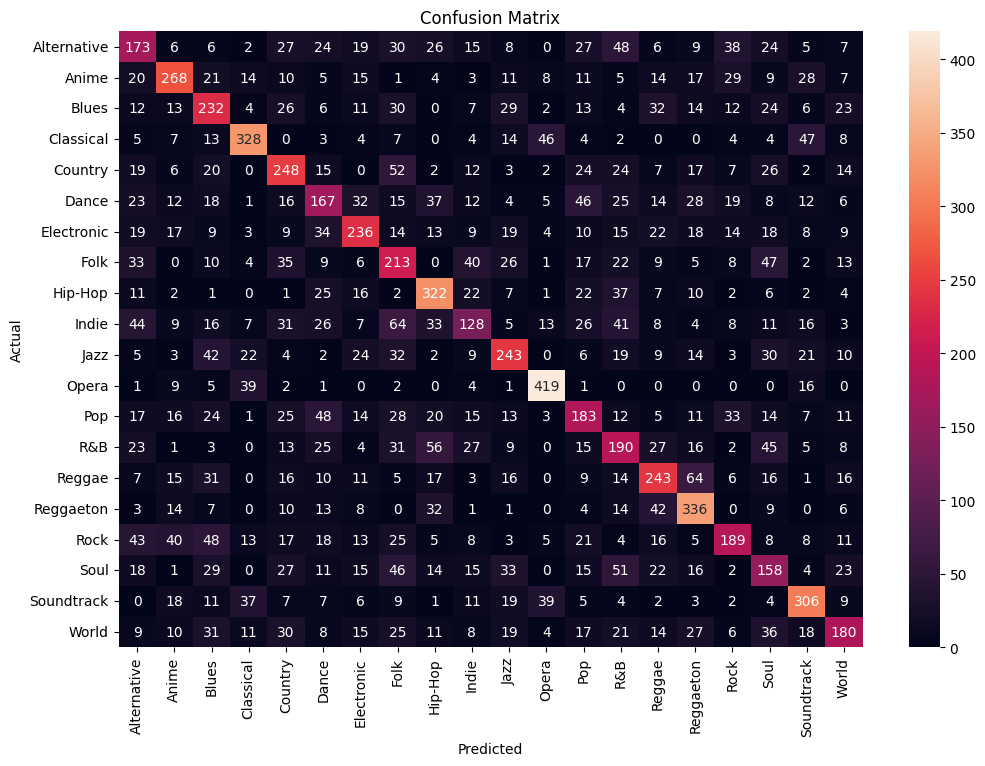

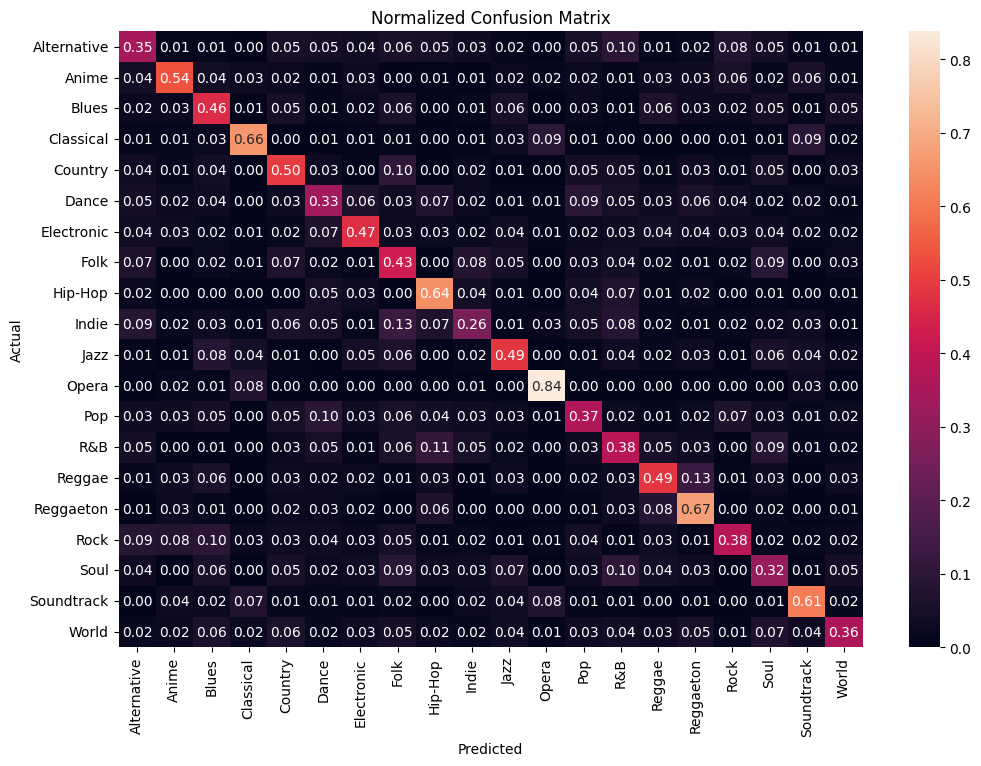

In [14]:
import seaborn as sns
from sklearn.metrics import confusion_matrix


conf_mat = confusion_matrix(y_test, y_pred)

labels = label_encoder.inverse_transform(range(len(label_encoder.classes_)))


# Plot confusion matrix
plt.figure(figsize=(12, 8))
sns.heatmap(conf_mat, annot=True, fmt="d", xticklabels=labels, yticklabels=labels)
plt.title("Confusion Matrix")
plt.ylabel("Actual")
plt.xlabel("Predicted")

# Compute normalized confusion matrix
normalized_conf_mat = conf_mat / conf_mat.sum(axis=1, keepdims=True)

# Plot normalized confusion matrix
plt.figure(figsize=(12, 8))
sns.heatmap(normalized_conf_mat, annot=True, fmt=".2f", xticklabels=labels, yticklabels=labels)
plt.title("Normalized Confusion Matrix")
plt.ylabel("Actual")
plt.xlabel("Predicted")

plt.show()